# Preliminary Experiment for _AKU_

Bernhard Bermeitinger, bernhard.bermeitinger@uni-passau.de

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
import os
import math
from glob import glob
import random
import re

In [3]:
import pandas as pd
import numpy as np

import cv2
from PIL import Image, ImageOps

import shutil
from joblib import Parallel, delayed

from tqdm.auto import tqdm

# Data Reading

In [4]:
DATA_DIR = os.path.join('/data', 'AKU', 'komplett')

In [5]:
gar_pattern = r"G[aA][rR][a-zA-Z]*[0-9]+"
moe_pattern = r"Moe[_]?[0-9]+[a-zA-Z]*"

raw_images = sorted([f for f in glob(os.path.join(DATA_DIR, "*.png"))])

images = []
labels_gar = []
labels_moe = []

for image in raw_images:
    image_file = os.path.basename(image)
    
    gar = re.findall(gar_pattern, image_file)
    if len(gar) == 0:
        print("gar not found:", os.path.basename(image))
        labels_gar.append(np.nan)
    else:
        labels_gar.append("gar_{}".format(gar[0].lower().split("gar")[1]))
    
    moe = re.findall(moe_pattern, image_file)
    if len(moe) == 0:
        print("moe not found:", os.path.basename(image))
        labels_moe.append(np.nan)
    else:
        labels_moe.append("moe_{}".format(moe[0].lower().split("moe")[1]))

    images.append(image)
    

moe not found: Gar0_192B_HT_pEbers_1_1.png
moe not found: Gar0_Mpe188B_HT_pEbers_95_8.png
moe not found: GarAa17_MoeBII594_HT_P_Paris_Louvre-E3226_1_8.png
moe not found: GarAa17_MoeBII594_HT_P_Paris_Louvre-E3226_38_1.png
moe not found: GarAa17_MoeBII594_HT_P_Paris_Louvre-E3226_4_9.png
moe not found: GarAa17_MoeBII594_HT_P_Paris_Louvre-E3226_8_1.png
moe not found: GarE9_Gar143_HT_P_NY_MMA_22-3-516_vo_6.png
gar not found: GarI_VerI14a_Moe247_HT_PBerlin_3050_3_6.png
gar not found: GarM(22)_Moe288_HT_pEbers_95_8.png
gar not found: GarN(35)_Moe333_HT_pEbers_32_17.png
gar not found: GarP(1)_Moe375_HT_pEbers_87_3.png
moe not found: GarY2_538var_HT_P_NY_MMA_22-3-518_vo_2.png
gar not found: Gar_Moe103B_HT_London_BM_EA_10188_12_Kph5.png
gar not found: Gar_Moe103B_HT_London_BM_EA_10188_12_Kph5_A.png
gar not found: Gar_Moe103B_HT_London_BM_EA_10188_12_Kph5_B.png
gar not found: Gar_Moe103B_HT_London_BM_EA_10188_12_Kph5_C.png
gar not found: Gar_Moe103B_HT_pA1956-313_7_8.png
gar not found: Gar_Moe103

In [6]:
possible_gar = [lbl for lbl in set(labels_gar) if lbl is not np.nan]
possible_moe = [lbl for lbl in set(labels_moe) if lbl is not np.nan]

In [7]:
print("There are {} different GAR labels".format(len(possible_gar)))
print("There are {} different MOE labels".format(len(possible_moe)))

There are 452 different GAR labels
There are 516 different MOE labels


In [8]:
print("There are {} images".format(len(images)))

There are 5710 images


## convert images to type 1 pngs 300x300

In [11]:
def convert(image_input, output_folder=None, size=(300, 300)):

    raw_img = cv2.imread(image_input, cv2.IMREAD_UNCHANGED)
    
    img = Image.fromarray(raw_img)
    img = img.resize(size)
    
    mask = None
    if len(raw_img.shape) == 3 and raw_img.shape[2] == 4:
        mask = img
    
    new_img = Image.new("L", size, color=255)

    if mask is None:
        new_img.paste(img)
    else:
        new_img.paste(img, mask=img)
    
    new_img = ImageOps.invert(new_img)

    new_img = new_img.convert('1')

    if output_folder is not None:
        new_img.save(os.path.join(output_folder, os.path.basename(image_input)))
    else:
        return new_img

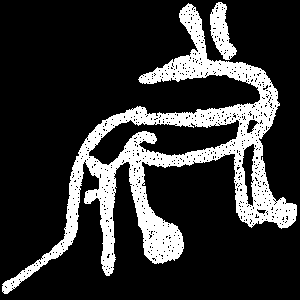

In [12]:
convert(images[8], None, (300, 300))

In [13]:
CONVERTED_OUTPUT = os.path.join(DATA_DIR, "converted")

if os.path.isdir(CONVERTED_OUTPUT):
    shutil.rmtree(CONVERTED_OUTPUT)

os.makedirs(CONVERTED_OUTPUT, exist_ok=True)

_ = Parallel(n_jobs=16)(delayed(convert)(img, CONVERTED_OUTPUT, (300, 300)) for img in tqdm(images))

## creating a CSV file for later

In [14]:
df = pd.DataFrame(columns=['image', 'gar_label', 'moe_label'])
df['image'] = [os.path.join(CONVERTED_OUTPUT, os.path.basename(im)) for im in images]
df['gar_label'] = labels_gar
df['moe_label'] = labels_moe

In [15]:
len(df)

5710

In [16]:
# remove rows where neither gar_label nor moe_label exist
df = df.dropna(subset=['gar_label', 'moe_label'], how='all')

In [17]:
len(df)

5710

In [18]:
df.to_csv(os.path.join(DATA_DIR, "data.csv"), index=None)